In [1]:
from PIL import Image
from scipy import misc
import pylab as plt
%matplotlib inline
import numpy as np
import skimage.transform
import pandas
import scipy.misc
import tensorflow 

from tensorflow import keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.utils import np_utils
from keras.models import load_model
import h5py

/Users/yack_domnicky/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def download_image(path):
    return misc.imread(path, mode='L')

def show_image(image):
    imgplot = plt.imshow(image, cmap='gray')
    plt.show()
    
def prepare_image(image, c=128):
    new_image = image.copy()
    for i in range(new_image.shape[0]):
        for j in range(new_image.shape[1]):
            if (new_image[i, j] < c):
                new_image[i, j] = 0
            else:
                new_image[i, j] = 1
    return new_image

def is_in_bounds(x, y, shape):
    return x > 0 and y > 0 and x < shape[0] and y < shape[1]
def is_ok(x, y, image):
    return  is_in_bounds(x, y, image.shape) and image[x, y] == 0 

turns = [[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]]

def dfs(cur_x, cur_y, image, used):
    for turn in turns:
        to_x = cur_x + turn[0]
        to_y = cur_y + turn[1]
        if (is_ok(to_x, to_y, image) and used[to_x, to_y] == 0):
            used[to_x, to_y] = used[cur_x, cur_y]
            dfs(to_x, to_y, image, used)

def divide_graph(image):
    used = np.zeros(image.shape)
    num = 0
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (used[i, j] == 0 and image[i, j] == 0):
                num += 1
                used[i, j] = num
                dfs(i, j, image, used)
    return num, used

def find_bounds(used):
    min_bounds = np.zeros((num + 1, 2))
    max_bounds = np.zeros((num + 1, 2))
    for i in range(1, num + 1):
        min_bounds[i, 0] = 10000000
        min_bounds[i, 1] = 10000000
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            k = int(used[i, j])
            if (min_bounds[k, 0] > i):
                min_bounds[k, 0] = i
            if (min_bounds[k, 1] > j):
                min_bounds[k, 1] = j
            if (max_bounds[k, 0] < i):
                max_bounds[k, 0] = i
            if (max_bounds[k, 1] < j):
                max_bounds[k, 1] = j
    return min_bounds, max_bounds

def filter_graph(num, used, min_bounds, max_bounds):
    actual_num = 0
    min_size = 10
    for k in range(1, num + 1):
        if (max_bounds[k, 0] - min_bounds[k, 0] < min_size and max_bounds[k, 1] - min_bounds[k, 1] < min_size):
            for i in range(used.shape[0]):
                for j in range(used.shape[1]):
                   if (int(used[i, j]) == k):
                       used[i, j] = 0
        else:
            actual_num += 1
            min_bounds[actual_num] = min_bounds[k]
            max_bounds[actual_num] = max_bounds[k]
            for i in range(used.shape[0]):
                for j in range(used.shape[1]):
                   if (int(used[i, j]) == k):
                       used[i, j] = actual_num   
    return actual_num

def print_obj(used, id):
    img = np.zeros(used.shape)
    for i in range(used.shape[0]):
        for j in range(used.shape[1]):
            img[i, j] = 1
            if (int(used[i, j]) == id):
                img[i, j] = 0
    show_image(img)

def print_all(used, num):
    print(num)
    for i in range(num):
        print_obj(component, i + 1)

def mark_up_findings(image, num, used, min_bounds, max_bounds):
    marked_image = image.copy()
    color = 0
    shape = marked_image.shape
    for k in range(1, num + 1):
        min_x = int(min_bounds[k, 0])
        min_y = int(min_bounds[k, 1])
        max_x = int(max_bounds[k, 0])
        max_y = int(max_bounds[k, 1])
        for i in range(min_x, max_x):
            marked_image[i, min_y] = color
            marked_image[i, max_y] = color
            if (min_y > 0):
                marked_image[i, min_y - 1] = color
            if (max_y > 0):
                marked_image[i, max_y - 1] = color
            if (min_y < shape[1] - 1):
                marked_image[i, min_y + 1] = color
            if (max_y < shape[1] - 1):
                marked_image[i, max_y + 1] = color
        for i in range(min_y, max_y):
            marked_image[min_x, i] = color
            marked_image[max_x, i] = color
            if (min_x > 0):
                marked_image[min_x - 1, i] = color
            if (max_x > 0):
                marked_image[max_x - 1, i] = color
            if (min_x < shape[0] - 1):
                marked_image[min_x + 1, i] = color
            if (max_x < shape[0] - 1):
                marked_image[max_x + 1, i] = color
    show_image(marked_image)
    
def maximum(x, y):
    return x * (x >= y) + y * (x < y)

def minimum(x, y):
    return x * (x <= y) + y * (x > y)

def delete_frames(image):
    for i in range(image.shape[0]):
        image[i][0] = 1
        image[i][image.shape[0] - 1] = 1
        image[0][i] = 1
        image[image.shape[0] - 1][i] = 1
    return image

def crop_image(image):
    size = 28
    times = 1.4
    cur_size = max(image.shape)
    
    tmp = np.ones((cur_size, cur_size))
    dx = (cur_size - image.shape[0]) // 2
    dy = (cur_size - image.shape[1]) // 2
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            tmp[i + dx, j + dy] = image[i, j]  
    image = tmp
    
    while (image.shape[0] < size * times) and (image.shape[1] < size * times):
        image = skimage.transform.resize(image, (int(image.shape[0] * times), int(image.shape[1] * times)))
        image = delete_frames(image)
                                         
    while (image.shape[0] > size) or (image.shape[1] > size):
        image = skimage.transform.resize(image, (int(image.shape[0] / times), int(image.shape[1] / times)))
        image = delete_frames(image)
                                         
    if (image.shape[0] <= size and image.shape[1] <= size):
        field_x = (size - image.shape[0]) // 2
        field_y = (size - image.shape[1]) // 2
        new_image = np.ones((size, size))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                new_image[i + field_x, j + field_y] = image[i, j]
        
        new_image = delete_frames(new_image)
        return new_image
    new_image = skimage.transform.resize(image, (size, size))
    
    new_image = delete_frames(new_image)
    return new_image
    
class Symbol:
    def __init__(self, image, min_x, max_x, min_y, max_y):
        self.image = image
        self.min_x = min_x
        self.max_x = max_x
        self.min_y = min_y
        self.max_y = max_y
        self.height = max_y - min_y
        self.width = max_x - min_x
    

def crop_findings(image, num, used, min_bounds, max_bounds):
    symbols = list()
    for k in range(1, num + 1):
        field = int(max_bounds[k, 0] + max_bounds[k, 1] - min_bounds[k, 0] - min_bounds[k, 1]) // 10
        #print(field)
        min_x = int(min_bounds[k, 0]) - field
        min_y = int(min_bounds[k, 1]) - field
        max_x = int(max_bounds[k, 0]) + field
        max_y = int(max_bounds[k, 1]) + field
        new_image = np.ones((max_x - min_x, max_y - min_y))
        for i in range(maximum(0, min_x), minimum(image.shape[0], max_x)):
            for j in range(maximum(0, min_y), minimum(image.shape[1], max_y)):
                if (int(used[i, j]) == k):
                    new_image[i - min_x, j - min_y] = 0
        symbol = Symbol(crop_image(new_image), min_y, max_y, min_x, max_x)
        symbols.append(symbol)
    return symbols

In [3]:
symb = '0123456789x'

def predict_number(symbol, model, model2, model3):
    image = symbol.image
    size = 28
    new_data = 1 - image.reshape((1, size, size, 1))
    pred = model.predict(new_data)
    maximum = -1
    number = -1
    for i in range(len(pred[0])):
        if pred[0, i] > maximum:
            maximum = pred[0, i]
            number = i
    return symb[number]

In [4]:
def tex_answer(symbols, model, model2 = None, model3 = None):
    
    string = list()
    for i in range(0, num):
        string.append((symbols[i].min_x, symbols[i].min_y, symbols[i]))
    string.sort()
    
    max_height = 0
    max_y = 0
    min_y = 100000
    for symbol in symbols:
        if (symbol.height > max_height):
            max_height = symbol.height
        if (symbol.max_y > max_y):
            max_y = symbol.max_y
        if (symbol.min_y < min_y):
            min_y = symbol.min_y
    middle = (max_y + min_y) // 2


    answer = list()

    for i in range(num):
        symbol = string[i][2]
        answer.append((predict_number(symbol, model, model2, model3), 'n'))
        if (symbol.height < max_height * 0.6):
            if (abs((symbol.min_y + symbol.max_y) / 2 - middle) < max_height * 0.3):
                answer[i] = ('+', 'n')
                if (max(symbol.height / symbol.width, symbol.width / symbol.height) > 2):
                    answer[i] = ('-', 'n')
            elif (symbol.min_y <= middle):
                answer[i] = (answer[i][0], 'u')
            elif (symbol.max_y >= middle):
                answer[i] = (answer[i][0], 'l')
            else:
                answer[i] = ('+', 'n')
    
    cur_upper = ''
    cur_lower = ''
    tex = ''
    
    for i in range(num):
        if (answer[i][1] == 'n'):
            if (len(cur_upper)):
                tex += '^{' + cur_upper + '}'
                cur_upper = ''
            if (len(cur_lower)):
                tex += '_{' + cur_lower + '}'
                cur_lower = ''
            tex += answer[i][0]
            continue
            
        
            
        if (answer[i][1] == 'u'):
            cur_upper += answer[i][0]
            continue

        if (answer[i][1] == 'l'):
            cur_lower += answer[i][0]
            continue
            
    if (len(cur_upper)):
        tex += '^{' + cur_upper + '}'
        cur_upper = ''
    if (len(cur_lower)):
        tex += '_{' + cur_lower + '}'
        cur_lower = ''

    return tex

In [5]:
modelZ = keras.models.load_model('Symbols_Fraiming/LastTryBest.h5')

/Users/yack_domnicky/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


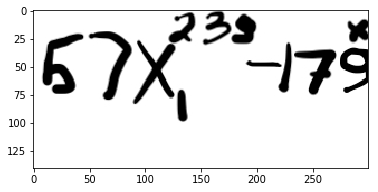

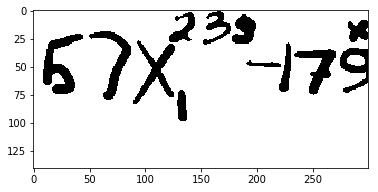

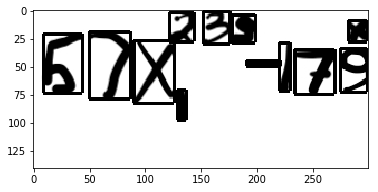

57x^{239}_{1}-179^{x}


/Users/yack_domnicky/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/yack_domnicky/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [17]:
try:
    img = download_image('Symbols_Fraiming/test2.jpg')
    show_image(img)
    prprd_img = prepare_image(img)
    show_image(prprd_img)
    if (img.shape[0] > 300 or img.shape[0] > 150):
        print('too large image')

    num, component = divide_graph(prprd_img)
    min_bounds, max_bounds = find_bounds(component)
    num = filter_graph(num, component, min_bounds, max_bounds)
    #print_all(component, num)
    mark_up_findings(img, num, component, min_bounds, max_bounds)
    symbols = crop_findings(prprd_img, num, component, min_bounds, max_bounds)

    answer = tex_answer(symbols, modelZ)
    print(answer)
except:
    print("Can't analize image")